# **Face Mask Classification 😷**

**Key Specifications**
* Data import: `flow_from_directory`
* Base-model: EfficientNetB3

**Additional Specifications**
* Image size: (256, 256, 3)
* Percentage for validation: 30%
* Batch size: 32
* Data augmentation: No
* Base-model non-trainable layers: 20 out of 384
* Post base-model layers:
    * Average 5x5
    * Dense with 512 neurons
    * Dropout with probability 50%

## **0.** Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display
from tensorflow.keras import regularizers
from collections import Counter
from tensorflow import keras
from IPython.utils import io

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns
import numpy as np
import math
import cv2
import os

# Warnings off
import warnings
warnings.filterwarnings("ignore")

## **1.** Dataset

In [ ]:
!unzip '/content/drive/MyDrive/Face Mask/dataset.zip'

In [ ]:
!ls /content

dataset  drive	sample_data


In [ ]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'dataset')

## **2.** Train and validation

In [ ]:
img_h = 256
img_w = 256
batch_size = 32

train = ImageDataGenerator(
    rescale          = 1./255, 
    validation_split = 0.3)

# In case we wanted to perform augmentation
train_aug = ImageDataGenerator(
    width_shift_range  = 10,
    height_shift_range = 10,
    zoom_range         = 0.3,
    horizontal_flip    = True,
    vertical_flip      = True,
    fill_mode          = 'constant',
    rescale            = 1./255, 
    validation_split   = 0.3)

train_dataset = train.flow_from_directory(
    dataset_dir, 
    target_size = (img_h, img_w), 
    batch_size  = batch_size, 
    class_mode  = 'categorical',
    subset      = 'training',
    shuffle     = True,
    seed        = 42)

validation_dataset = train.flow_from_directory(
    dataset_dir, 
    target_size = (img_h, img_w), 
    batch_size  = batch_size, 
    class_mode  = 'categorical',
    subset      = 'validation',
    shuffle     = False,
    seed        = 42)

classes = train_dataset.class_indices
num_classes = len(classes)
print("There are ", num_classes, "classes: ", classes)

reversed_classes = {value : key for (key, value) in classes.items()}
print(reversed_classes)

Found 3930 images belonging to 3 classes.
Found 1684 images belonging to 3 classes.
There are  3 classes:  {'0': 0, '1': 1, '2': 2}
{0: '0', 1: '1', 2: '2'}


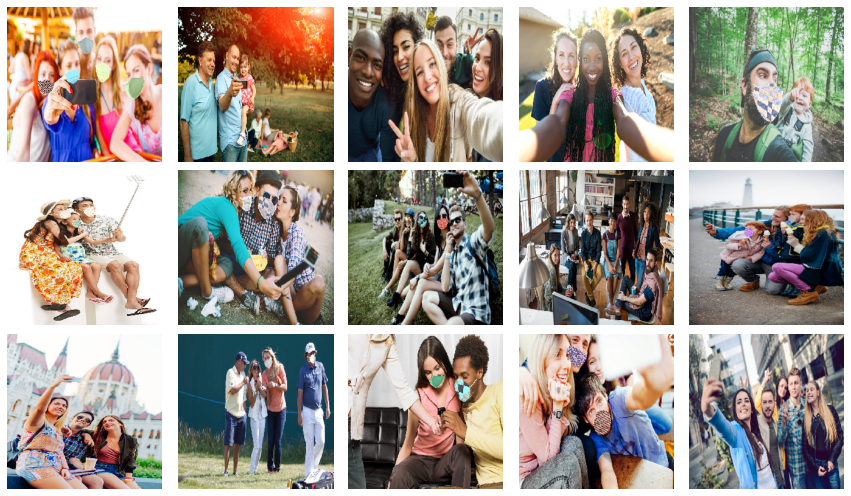

In [ ]:
# Visualize some images 
plt.figure(figsize=(15, 9))
for i in range(15):
    img, label = train_dataset.next()
    plt.subplot(3, 5, i+1)
    plt.imshow(img[0])
    plt.axis('off')

plt.subplots_adjust(wspace=.1, hspace=.01)

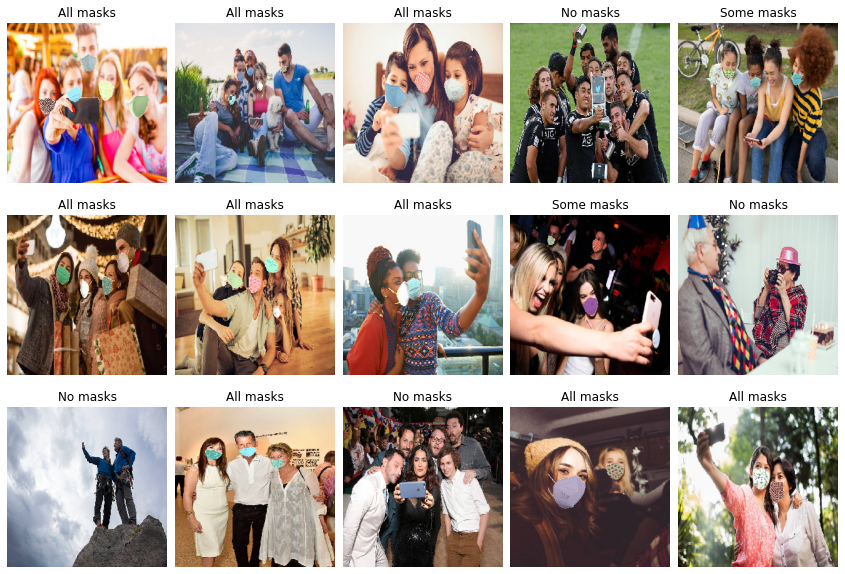

In [ ]:
# Visualize some images with predicted class
plt.figure(figsize=(15,10))

# To not have unwanted text output (warnings, etc.)
with io.capture_output() as captured:
  for i in range(15):
    plt.subplot(3, 5, i+1);
    plt.imshow(train_dataset[0][0][i]);
    if np.argmax(train_dataset[0][1][i]) == 0:
      plt.title('No masks');
    elif np.argmax(train_dataset[0][1][i]) == 1:
      plt.title('All masks');
    elif np.argmax(train_dataset[0][1][i]) == 2:
      plt.title('Some masks')
    plt.axis('off')

  plt.subplots_adjust(wspace=.01, hspace=.2)

## **3.** Classes analysis

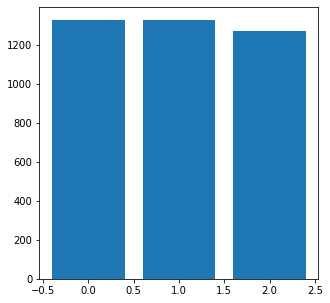

In [ ]:
# Count the number of images for each class and construct a dict: {class: num_images}
classes_names = Counter(train_dataset.classes).keys()
classes_values = Counter(train_dataset.classes).values()

# Define the dict
class_dict = {list(classes_names)[0]: list(classes_values)[0],
              list(classes_names)[1]: list(classes_values)[1],
              list(classes_names)[2]: list(classes_values)[2]}

# Plot
fig, ax = plt.subplots(figsize=(5,5));
ax.bar(class_dict.keys(), class_dict.values());

## **4.** Define the model

In [ ]:
# Base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top = False,
    weights     = "imagenet",
    input_shape = (img_h, img_w, 3))

# Unfreeze all the layers
for layer in base_model.layers:
    layer.trainable = True

# Freeze the first 20 layers (out of 384)
for layer in base_model.layers[:20]:
    layer.trainable = False

# Build the model
x = tf.identity(base_model.output)
x = tf.keras.layers.AveragePooling2D(pool_size=(5,5))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
# Model visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# To get exact numbers
model.summary()

# Output:
# ==================================================================================================
# Total params: 11,572,018
# Trainable params: 11,480,993
# Non-trainable params: 91,025
# __________________________________________________________________________________________________

## **5.** Compile and train the model

In [ ]:
# Maximum number of epochs
num_epochs = 500

# Optimizer
optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

# Loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Metrics
metrics = ['accuracy']

# Compile
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# To save the model
filepath = '/content/drive/MyDrive/Face Mask/' + 'model_01.hdf5'

# Callbacks
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor              = "val_loss", 
    restore_best_weights = False, 
    verbose              = 1, 
    patience             = 10)

Learning_Rate_Adapter = tf.keras.callbacks.ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.2, 
    patience = 3, 
    verbose  = 1, 
    mode     = 'auto')

Best_model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath       = filepath, 
    save_best_only = True, 
    monitor        = 'val_loss', 
    mode           = 'min', 
    verbose        = True)

callback = [Early_Stopping, Learning_Rate_Adapter, Best_model_save]

In [ ]:
history = model.fit(
    train_dataset, 
    epochs          = num_epochs, 
    validation_data = validation_dataset, 
    callbacks       = callback)

Epoch 1/500
123/123 [==============================] - ETA: 0s - loss: 1.4673 - accuracy: 0.6509
Epoch 1: val_loss improved from inf to 1.80957, saving model to /content/drive/MyDrive/Face Mask/model_01.hdf5
123/123 [==============================] - 122s 774ms/step - loss: 1.4673 - accuracy: 0.6509 - val_loss: 1.8096 - val_accuracy: 0.3385 - lr: 1.0000
Epoch 2/500
123/123 [==============================] - ETA: 0s - loss: 1.0505 - accuracy: 0.8282
Epoch 2: val_loss did not improve from 1.80957
123/123 [==============================] - 87s 704ms/step - loss: 1.0505 - accuracy: 0.8282 - val_loss: 2.4435 - val_accuracy: 0.3385 - lr: 1.0000
Epoch 3/500
123/123 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.9071
Epoch 3: val_loss did not improve from 1.80957
123/123 [==============================] - 87s 708ms/step - loss: 0.8148 - accuracy: 0.9071 - val_loss: 4.3890 - val_accuracy: 0.3385 - lr: 1.0000
Epoch 4/500
123/123 [==============================] - ETA: 0s

## **6.** Model performance

### **6.1.** Trend of training loss and validation loss

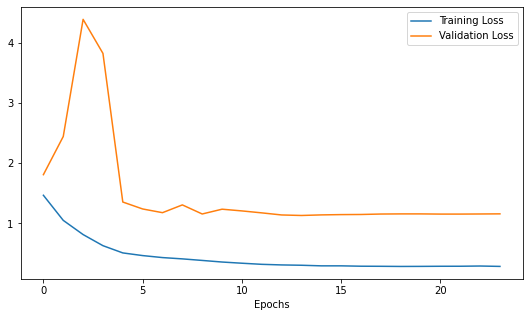

In [ ]:
plt.figure(figsize=(9,5));
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.legend();
plt.xlabel('Epochs');

### **6.2.** Confusion matrix

In [ ]:
# Load and evaluate the best model version
model = tf.keras.models.load_model(filepath)

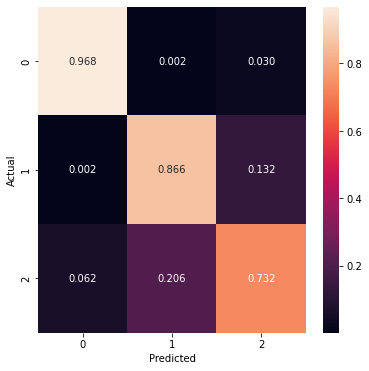

In [ ]:
keys = classes.keys()

y_pred = []  # store predicted labels
y_true = []  # store true labels

# For each validation image we get a probability vector on the classes, we collect everything in "values"
values = model.predict(validation_dataset)

# For each validation image we assign the class corresponding to the highest probability, we collect everything in "predictions"
predictions = []
for n in range(len(values)):
  y_pred.append(np.argmax(values[n], axis=-1))

y_true = validation_dataset.classes
  
# Convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# Build the confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=keys, yticklabels=keys);
plt.ylabel('Actual');
plt.xlabel('Predicted');

### **6.3** Other indeces

In [ ]:
# Micro
# Calculate metrics globally by counting the total true positives, false negatives and false positives.
print('-----------------------------')
print('MICRO')
print('-----------------------------')
print('Precision: %.5f' %precision_score(correct_labels, predicted_labels, pos_label='positive', average='micro'))
print('Recall: %.5f' % recall_score(correct_labels, predicted_labels, pos_label='positive', average='micro'))
print('Accuracy: %.5f' % accuracy_score(correct_labels, predicted_labels))
print('F1: %.5f' % f1_score(correct_labels, predicted_labels, pos_label='positive', average='micro'))

# Macro
# Calculate metrics for each label, and find their unweighted mean.
# This does not take label imbalance into account.
print('-----------------------------')
print('MACRO')
print('-----------------------------')
print('Precision: %.5f' %precision_score(correct_labels, predicted_labels, pos_label='positive', average='macro'))
print('Recall: %.5f' % recall_score(correct_labels, predicted_labels, pos_label='positive', average='macro'))
print('Accuracy: %.5f' % accuracy_score(correct_labels, predicted_labels))
print('F1: %.5f' % f1_score(correct_labels, predicted_labels, pos_label='positive', average='macro'))

# Weighted
# Calculate metrics for each label, and find their average weighted by the number of true instances for each label.
# This alters ‘macro’ to account for label imbalance.
print('-----------------------------')
print('WEIGHTED')
print('-----------------------------')
print('Precision: %.5f' %precision_score(correct_labels, predicted_labels, pos_label='positive', average='weighted'))
print('Recall: %.5f' % recall_score(correct_labels, predicted_labels, pos_label='positive', average='weighted'))
print('Accuracy: %.5f' % accuracy_score(correct_labels, predicted_labels))
print('F1: %.5f' % f1_score(correct_labels, predicted_labels, pos_label='positive', average='weighted'))

-----------------------------
MICRO
-----------------------------
Precision: 0.85748
Recall: 0.85748
Accuracy: 0.85748
F1: 0.85748
-----------------------------
MACRO
-----------------------------
Precision: 0.85551
Recall: 0.85565
Accuracy: 0.85748
F1: 0.85454
-----------------------------
WEIGHTED
-----------------------------
Precision: 0.85617
Recall: 0.85748
Accuracy: 0.85748
F1: 0.85580


## **7.** Prediction

In [ ]:
# Load and evaluate the best model version
model = tf.keras.models.load_model(filepath)

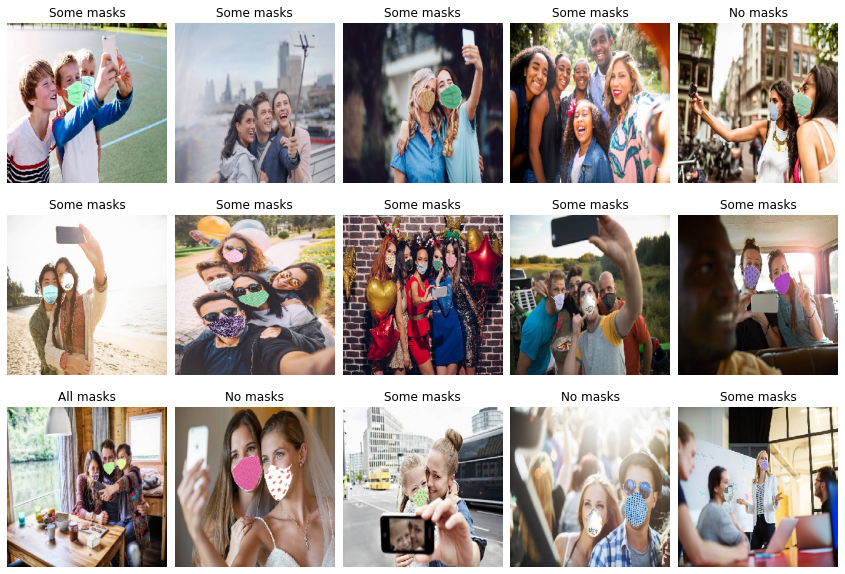

In [ ]:
# Visualize the images with the predicted class
plt.figure(figsize=(15,10))

path_img_test = '/content/drive/MyDrive/Face Mask/test'

n = 0
for i in os.listdir(path_img_test):
  
  # Load image
  img = image.load_img(path_img_test + '/' + i, target_size=(img_h, img_w))
  
  # Define the plot
  plt.subplot(3, 5, n+1)
  plt.imshow(img)
  plt.axis("off")

  # Define the label
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  if np.argmax(model.predict(images))==0:
    plt.title('No masks')
  elif np.argmax(model.predict(images))==1:
    plt.title('All masks')
  else:
    plt.title('Some masks')

  # Iter
  n = n+1

plt.subplots_adjust(wspace=.01, hspace=.2)

## **8.** GradCAM

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

    return cam_path

The heatmap: 


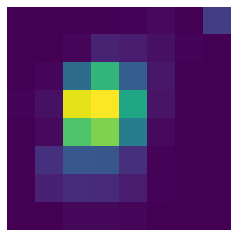


The image with the heatmap: 


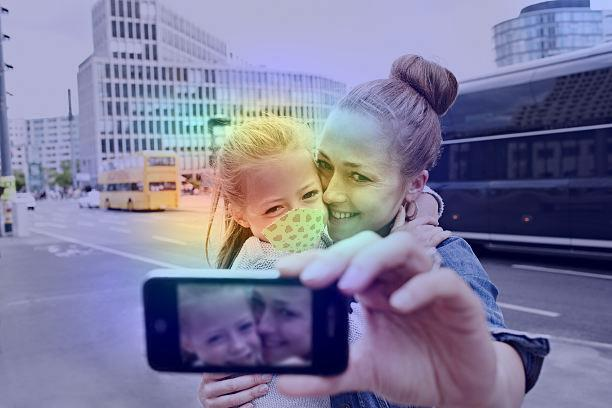

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'tf.identity'

# The local path to our target image
img_path  = '/content/drive/MyDrive/Face Mask/test/10040.jpg'
img_array = get_img_array(img_path, size=(img_h, img_w))
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
print("The heatmap: ")
plt.matshow(heatmap)
plt.axis('off')
plt.show()

# Display the image
print("\nThe image with the heatmap: ")
image = Image(save_and_display_gradcam(img_path, heatmap), width = 500, height = 350)
display(image)

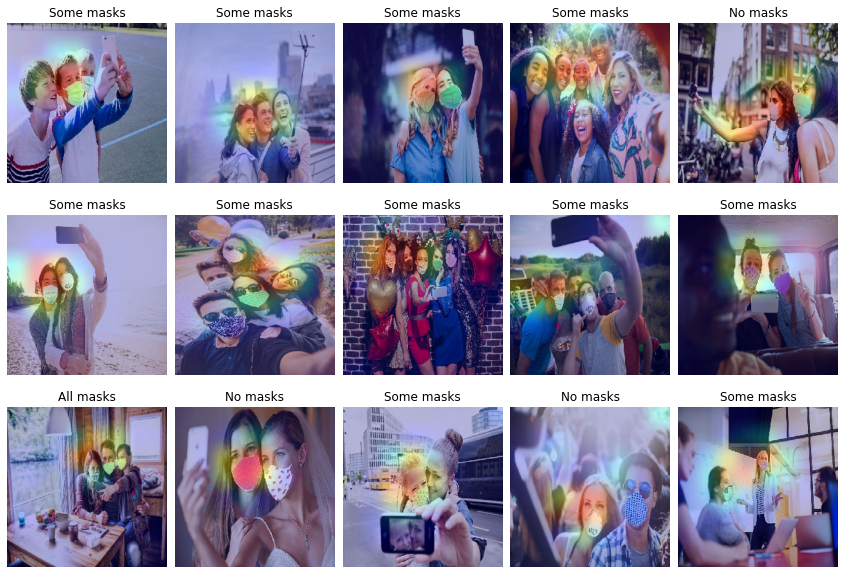

In [ ]:
from keras.preprocessing import image

# Visualize the images with the predicted class
plt.figure(figsize=(15,10))

# For the GradCam (remove the last layer - softmax)
model.layers[-1].activation = None

n = 0
for i in os.listdir(path_img_test):
  
  # Load image
  img = image.load_img(path_img_test + '/' + i, target_size=(img_h, img_w))
  
  # GradCam
  img_path = path_img_test + '/' + i
  img_array = get_img_array(img_path, size=(img_h, img_w))
  img_array = preprocess_input(get_img_array(img_path, size=(img_h, img_w)))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  img_2 = save_and_display_gradcam(img_path, heatmap)
  img_2 = image.load_img(img_2, target_size = (img_h, img_w))

  # Define the plot
  plt.subplot(3, 5, n+1)
  plt.imshow(img_2)
  plt.axis("off")

  # Define the label
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  if np.argmax(model.predict(images))==0:
    plt.title('No masks')
  elif np.argmax(model.predict(images))==1:
    plt.title('All masks')
  else:
    plt.title('Some masks')

  # Iter
  n = n+1

plt.subplots_adjust(wspace=.01, hspace=.2)